In [1]:
import numpy as np

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.utils import R_trendfilter
from mrashpen.inference.mrash_wrapR import MrASHR
from mrashpen.models.mixture_gaussian import emfit

from gradvi.inference import LinearRegression, Trendfiltering
from gradvi.normal_means import NormalMeans, NormalMeansFromPosterior
from gradvi.tests import toy_priors, toy_data
from gradvi.optimize import moving_average as gvma
from gradvi.models import basis_matrix as gvbm
from gradvi.models import TrendfilteringModel

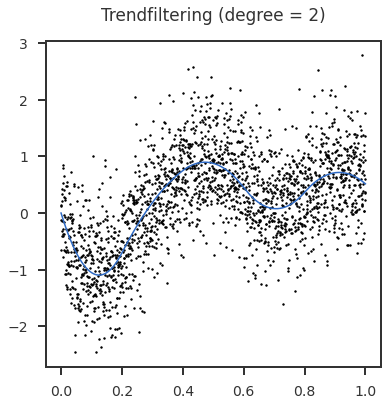

In [34]:
n = 2048
x = np.linspace(0, 1, n)
np.random.seed(100)

degree = 2
nknots = 4
strue  = 0.6
knots  = np.linspace(0, 1, nknots+2)[1:-1]

data = toy_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                        signal = "normal", seed = 100,
                        include_intercept = False)

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)
fig = plt.figure(figsize = (6, 6))

ax = fig.add_subplot(1, 1, 1)
ax.scatter(data.x, data.y, s = 2, color = 'black')
ax.plot(data.x, data.ytrue)
ax.set_title(f"Trendfiltering (degree = {degree})", pad = 20)

plt.show()

In [35]:
s2_true = np.var(data.y - data.ytrue)

H = gvbm.trendfiltering(n, degree)
Hinv = gvbm.trendfiltering_inverse(n, degree)

In [36]:
Ddoty = np.zeros_like(data.y)
Ddoty[degree + 1:] = np.diff(data.y, n = degree + 1)
for i in range(degree + 1):
    Ddoty[i] = np.diff(data.y[:i+1], n = i)

In [37]:
np.allclose(Ddoty,np.dot(Hinv, data.y))

True

## Normal Means model with prior on Db

In [38]:
# sample Db from N(0, sk^2)
sk = 1.5
theta = np.random.normal(loc = 0, scale = sk, size = n)

# sample b from N(0, Dinv.S.DinvT)
Scov = np.eye(n) * np.square(sk)
ScovDinv = np.dot(H, np.dot(Scov, H.T))
mu = np.random.multivariate_normal(np.zeros(n), ScovDinv)

/tmp/ipykernel_142343/276238264.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  mu = np.random.multivariate_normal(np.zeros(n), ScovDinv)


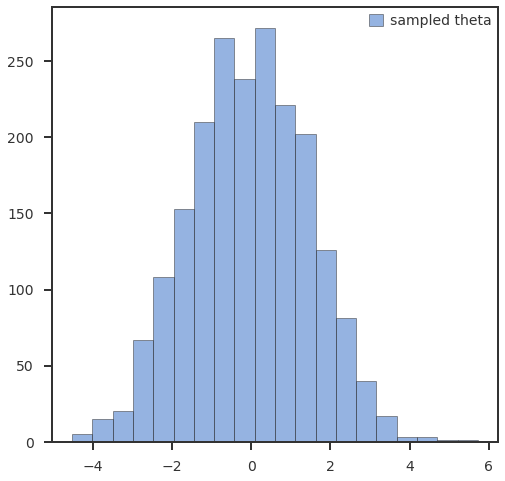

In [43]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(theta, label = "sampled theta", alpha = 0.5)
#ax1.hist(np.dot(Hinv, mu), label = "sampled mu", alpha = 0.5)
#ax1.hist(mu_sample, label = "prior on b")

ax1.legend()
plt.show()

## Time series data

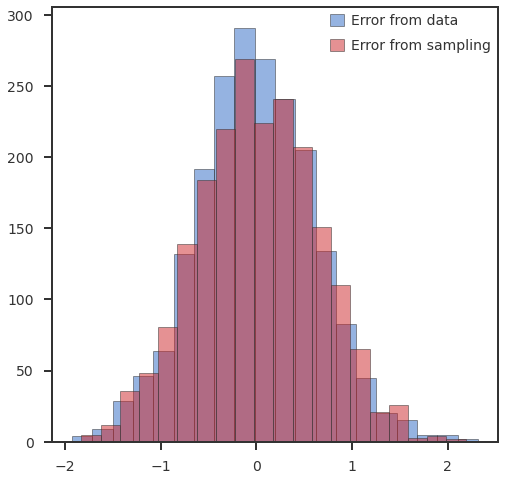

In [44]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.hist(data.y - data.ytrue, label = "Error from data", alpha = 0.5)
noise = np.random.normal(0, np.sqrt(s2_true), size = n)
ax1.hist(noise, label = "Error from sampling", alpha = 0.5)
ax1.legend()
plt.show()

### Multiply data with D on both sides

In [45]:
Omega = s2_true * np.dot(Hinv, Hinv.T)

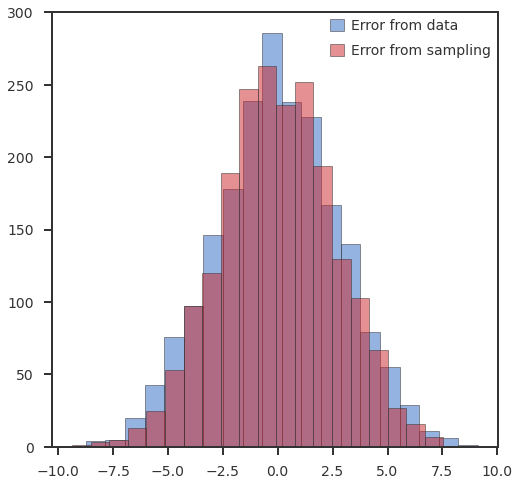

In [46]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.hist(np.dot(Hinv, data.y - data.ytrue), label = "Error from data", alpha = 0.5)
noise = np.random.multivariate_normal(np.zeros(n), Omega)
ax1.hist(noise, label = "Error from sampling", alpha = 0.5)
ax1.legend()
plt.show()

In [54]:
Omega_inv = np.linalg.inv(Omega)
Omega[np.where(Omega < 0)]

array([-0.37941899, -0.37941899, -0.37941899, ..., -5.6912849 ,
       -0.37941899, -5.6912849 ])

In [56]:
H

array([[1.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.000000e+00, 1.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.000000e+00, 2.000000e+00, 1.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.000000e+00, 2.045000e+03, 2.089990e+06, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.000000e+00, 2.046000e+03, 2.092035e+06, ..., 3.000000e+00,
        1.000000e+00, 0.000000e+00],
       [1.000000e+00, 2.047000e+03, 2.094081e+06, ..., 6.000000e+00,
        3.000000e+00, 1.000000e+00]])

In [53]:
np.where(Omega < 0)

(array([   0,    0,    1, ..., 2046, 2047, 2047]),
 array([   1,    3,    0, ..., 2047, 2044, 2046]))

In [47]:
X = np.sqrt(np.linalg.inv(Omega))

/tmp/ipykernel_142343/738738089.py:1: RuntimeWarning: invalid value encountered in sqrt
  X = np.sqrt(np.linalg.inv(Omega))


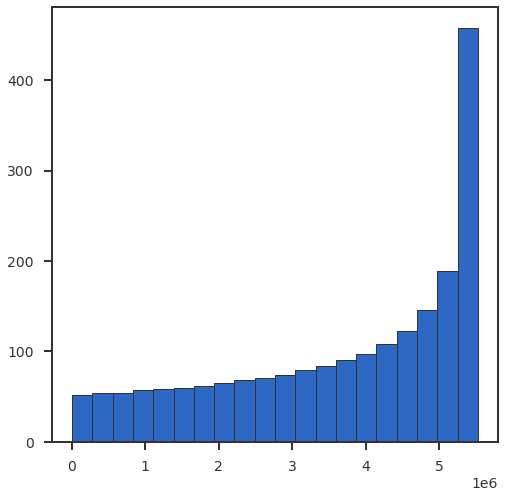

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

dj = np.sum(np.square(X), axis = 0)
ax1.hist(dj)
plt.show()

In [31]:
np.max(dj)

5527022.1977501465